# Preparing the environment

In [2]:
pip install findspark


In [3]:
import findspark
findspark.init()

In [4]:
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col, explode, initcap, regexp_replace, split, concat, substring, to_date
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DoubleType

In [5]:
spark = SparkSession \
        .builder \
        .appName("PySparkGooglePlayApps") \
        .getOrCreate()

# Dataset

The dataset that I used to work with has been taken from Kaggle:<br>
https://www.kaggle.com/lava18/google-play-store-apps

In this dataset we have 2 files: `googleplaystore.csv` (Apps) and `googleplaystore_user_reviews.csv` (Reviews).<br>
I will call them **Apps** and **User reviews** respectively.<br>

## Data Wrangling - Apps

Since some of the app names have a double quotation mark, we should indicate to `spark.read.load` that this character has to be escaped. Otherwise, we would have extra columns in the Dataframe.

In [6]:
apps = spark.read.load("googleplaystore.csv",
                    format='csv',
                    sep = ',',
                    header='true',
                    escape='"',
                    inferSchema='true')

Check that those App names have been correctly loaded:

In [7]:
apps.select("App").where("App like '%\"%'").show(truncate=False)

+------------------------------------------------------+
|App                                                   |
+------------------------------------------------------+
|Eat Fast Prepare "Without Internet"                   |
|Yanosik: "antyradar", traffic jams, navigation, camera|
|Alphabet "H" Passcode Lock Screen                     |
|Official QR Code® Reader "Q"                          |
|Women"s Health Tips(Breast,Face,Body,weight lose)     |
|"i DT" Fútbol. Todos Somos Técnicos.                  |
|The FN "Baby" pistol explained                        |
+------------------------------------------------------+



In [8]:
# Number of rows in the dataframe
apps.count()

10841

### Transformations & Datatype conversions
To understand what we are going to do, let's first take a look at the data and the schema of the Dataframe:

In [9]:
apps.show()


+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|    10,000+|Free|    0|      Everyone|        Art & Design|   January 7, 2018|             1.0.0|4.0.3 and up|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|   500,000+|Free|    0|      Everyone|Art & Design;Pret...|  January 15, 2018|             2.0.0|4.0.3 and up|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510|8.7M| 5,000,000+|Free|    0|      Everyone|        Art & Design|    August 1, 2018|             1.2.4|4.0.3 

In [10]:
apps.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



For this analysis we don't need all the columns but only a few of them, so let's start by dropping unwanted columns:

In [11]:
# Drop unused columns
apps = apps.drop("category", "size", "type", "content rating")

Now we are going to focus on the following points:
1. **Column renaming**: Removing spaces.
1. **Rating**: Cast  to Double.
1. **Installs**: Apply regexp to remove unwanted characters and cast to Integer.
1. **Price**: Apply regexp to remove unwanted characters and cast to Double.
1. **Last updated**: Cast to Date.

In [12]:
apps = apps \
    .withColumnRenamed("Android Ver", "android_ver") \
    .withColumnRenamed("Current Ver", "current_ver") \
    .withColumnRenamed("Last Updated", "last_updated") \
    .withColumn("Rating", col("Rating").cast(DoubleType())) \
    .withColumn("Reviews", col("Reviews").cast(IntegerType())) \
    .withColumn("Installs", regexp_replace(col("Installs"), "[^0-9]", "")) \
    .withColumn("Installs", col("Installs").cast(IntegerType())) \
    .withColumn("Price", regexp_replace(col("Price"), "[$]", "")) \
    .withColumn("Price", col("Price").cast(DoubleType())) \
    .withColumn("last_updated", to_date('last_updated', 'MMM d, yyyy'))

In [13]:
# Fill NULL values with 0
apps = apps.fillna(0, "price")

With the new datatypes and cleaning actions, now the schema and data makes more sense.

In [14]:
apps.printSchema()

root
 |-- App: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Installs: integer (nullable = true)
 |-- Price: double (nullable = false)
 |-- Genres: string (nullable = true)
 |-- last_updated: date (nullable = true)
 |-- current_ver: string (nullable = true)
 |-- android_ver: string (nullable = true)



In [15]:
apps = spark.read.csv("googleplaystore.csv", header=True, inferSchema=True)
apps.show()


+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|    10,000+|Free|    0|      Everyone|        Art & Design|   January 7, 2018|             1.0.0|4.0.3 and up|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|   500,000+|Free|    0|      Everyone|Art & Design;Pret...|  January 15, 2018|             2.0.0|4.0.3 and up|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510|8.7M| 5,000,000+|Free|    0|      Everyone|        Art & Design|    August 1, 2018|             1.2.4|4.0.3 

### Removing duplicates

According to the information that Kaggle shows about the dataset, there are 9660 unique values. Let's see then how to remove them.<br>
I applied my personal criteria for selecting the columns for which I will decide what is **unique**, but this could be different according to different business needs.

In [16]:
#Create temporal view so later we can execute SQL statements
apps.createOrReplaceTempView("apps")

In [17]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("PySparkGooglePlayApps") \
    .getOrCreate()


In [18]:
apps.createOrReplaceTempView("apps")

spark.sql("""
SELECT App, Rating, Reviews, Installs, Genres, Price, `Android Ver`, COUNT(*) AS rep
FROM apps
GROUP BY App, Rating, Reviews, Installs, Genres, Price, `Android Ver`
HAVING COUNT(*) > 1
ORDER BY rep DESC
""").show()


+--------------------+------+-------+------------+--------------------+-----+------------------+---+
|                 App|Rating|Reviews|    Installs|              Genres|Price|       Android Ver|rep|
+--------------------+------+-------+------------+--------------------+-----+------------------+---+
|           WatchESPN|   4.1| 288809| 10,000,000+|              Sports|    0|        4.4 and up|  4|
|Quizlet: Learn La...|   4.6| 211856| 10,000,000+|           Education|    0|Varies with device|  4|
|eBay: Buy & Sell ...|   4.4|2788923|100,000,000+|            Shopping|    0|Varies with device|  4|
|CBS Sports App - ...|   4.3|  91031|  5,000,000+|              Sports|    0|        5.0 and up|  4|
|          Skyscanner|   4.5| 481546| 10,000,000+|      Travel & Local|    0|        4.4 and up|  4|
|                Nick|   4.2| 123279| 10,000,000+|Entertainment;Mus...|    0|        4.4 and up|  4|
|         Google Keep|   4.4| 691474|100,000,000+|        Productivity|    0|Varies with de

In the following example we can see one specific app with almost identical rows, the only difference is in the number of reviews and version (both *current_ver* and *last_updated*).

In [19]:
spark.sql("""
SELECT  App, Rating, Reviews, Installs, Price,
        Genres, `Last Updated`, `Current Ver`, `Android Ver`,
        ROW_NUMBER() OVER (
            PARTITION BY App
            ORDER BY `Current Ver` DESC, `Last Updated` DESC, Reviews DESC
        ) AS row_number
FROM apps
WHERE App = "Farm Heroes Saga"
""").show(truncate=False)


+----------------+------+-------+------------+-----+------+--------------+-----------+-----------+----------+
|App             |Rating|Reviews|Installs    |Price|Genres|Last Updated  |Current Ver|Android Ver|row_number|
+----------------+------+-------+------------+-----+------+--------------+-----------+-----------+----------+
|Farm Heroes Saga|4.4   |7615646|100,000,000+|0    |Casual|August 7, 2018|5.2.6      |2.3 and up |1         |
|Farm Heroes Saga|4.4   |7614415|100,000,000+|0    |Casual|July 26, 2018 |5.1.8      |2.3 and up |2         |
|Farm Heroes Saga|4.4   |7614407|100,000,000+|0    |Casual|July 26, 2018 |5.1.8      |2.3 and up |3         |
|Farm Heroes Saga|4.4   |7614271|100,000,000+|0    |Casual|July 26, 2018 |5.1.8      |2.3 and up |4         |
|Farm Heroes Saga|4.4   |7614130|100,000,000+|0    |Casual|July 26, 2018 |5.1.8      |2.3 and up |5         |
+----------------+------+-------+------------+-----+------+--------------+-----------+-----------+----------+



Finally, to **remove duplicates** we are going to use the SQL analytical function `ROW_NUMBER()` establishing one specific order, and keeping only the first row of each app.

In [20]:
apps = spark.sql("""
WITH app_vw AS (
    SELECT App, Rating, Reviews, Installs, Price, Genres, `Last Updated`, `Current Ver`, `Android Ver`,
           ROW_NUMBER() OVER (
               PARTITION BY App
               ORDER BY `Current Ver` DESC, `Last Updated` DESC, Reviews DESC
           ) AS row_number
    FROM apps
)
SELECT App, Rating, Reviews, Installs, Price, Genres, `Last Updated`, `Current Ver`, `Android Ver`
FROM app_vw
WHERE row_number = 1
""")


In [21]:
apps.count()

9660

The following Dataframe method will only remove completely identical rows by looking at **all the columns**.<br>
Since we have already removed the duplicates, it will have no effect on the Dataframe.

In [22]:
apps = apps.dropDuplicates()

In [23]:
apps.count()

9660

In [24]:
spark.sql("""
SELECT app, rating, reviews, installs, genres, price, `Android Ver`, count(*) rep
FROM apps
GROUP BY app, rating, reviews, installs, genres, price, `Android Ver`
HAVING count(*) > 1
""").show()


+--------------------+------+--------+------------+--------------------+------+------------------+---+
|                 app|rating| reviews|    installs|              genres| price|       Android Ver|rep|
+--------------------+------+--------+------------+--------------------+------+------------------+---+
|Runkeeper - GPS T...|   4.5|  501144| 10,000,000+|    Health & Fitness|     0|Varies with device|  2|
|PMHNP-BC Pocket Prep|   4.4|     112|      1,000+|             Medical|     0|        4.4 and up|  2|
|Gyft - Mobile Gif...|   4.1|    9701|    500,000+|            Shopping|     0|        4.4 and up|  3|
|    Google Analytics|   4.5|   78662|  1,000,000+|            Business|     0|        4.4 and up|  2|
|Sniper 3D Gun Sho...|   4.6| 7672495|100,000,000+|              Action|     0|Varies with device|  2|
|All Mental disorders|   4.5|     453|    100,000+|             Medical|     0|      4.0.3 and up|  2|
|Newsroom: News Wo...|   4.2|  201737| 10,000,000+|    News & Magazines| 

Category with highest reviews: SOCIAL
Category with highest installs: SOCIAL


/tmp/ipython-input-26-2836839636.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_review_data.values, y=top_review_data.index, ax=ax[0], palette="viridis")
/tmp/ipython-input-26-2836839636.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_install_data.values, y=top_install_data.index, ax=ax[1], palette="magma")


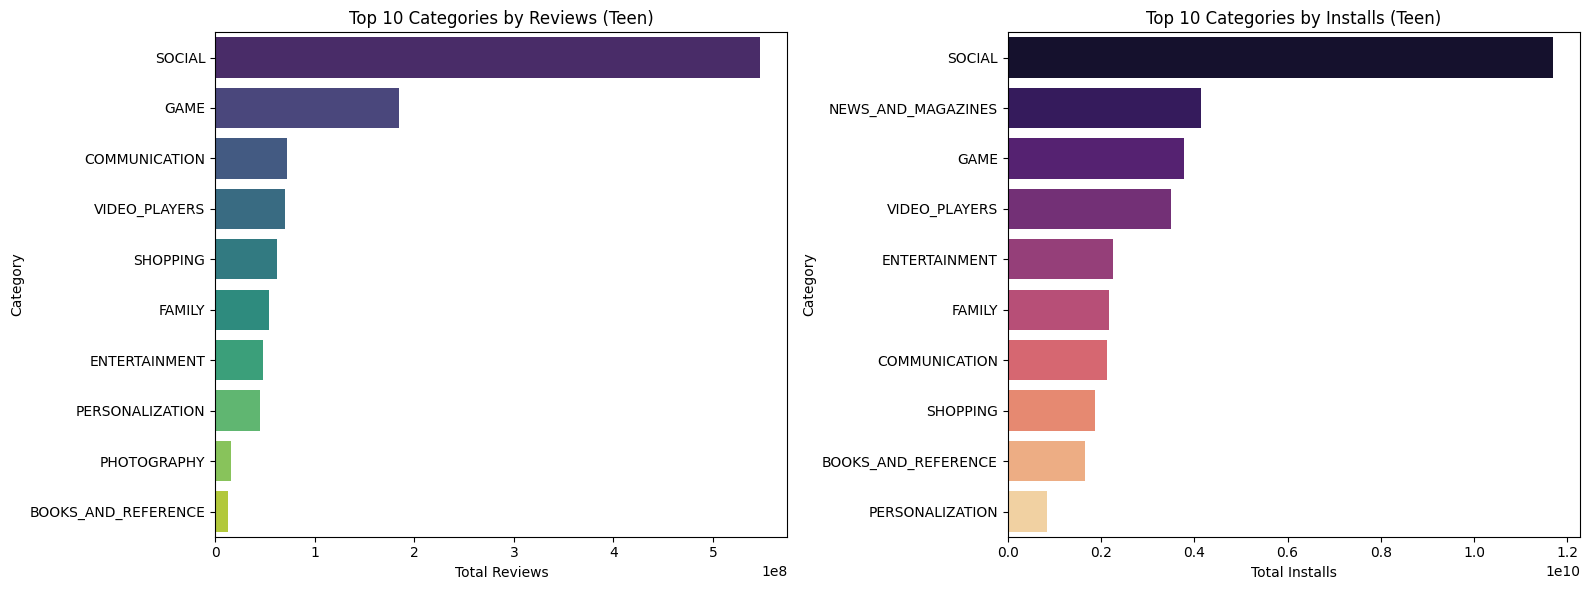

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("googleplaystore.csv")

# Step 1: Filter content rating as 'Teen'
df_cleaned = df[df["Content Rating"] == "Teen"].copy()

# Step 2: Clean and convert 'Reviews' and 'Installs' columns
df_cleaned["Reviews"] = pd.to_numeric(df_cleaned["Reviews"], errors='coerce')
df_cleaned["Installs"] = df_cleaned["Installs"].str.replace("[+,]", "", regex=True)
df_cleaned["Installs"] = pd.to_numeric(df_cleaned["Installs"], errors='coerce')

# Drop rows with missing values
df_cleaned.dropna(subset=["Category", "Reviews", "Installs"], inplace=True)

# Step 3: Find category with highest total Reviews and Installs
top_review_category = df_cleaned.groupby("Category")["Reviews"].sum().idxmax()
top_install_category = df_cleaned.groupby("Category")["Installs"].sum().idxmax()

print("Category with highest reviews:", top_review_category)
print("Category with highest installs:", top_install_category)

# Step 4: Plot the data
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 by Reviews
top_review_data = df_cleaned.groupby("Category")["Reviews"].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_review_data.values, y=top_review_data.index, ax=ax[0], palette="viridis")
ax[0].set_title("Top 10 Categories by Reviews (Teen)")
ax[0].set_xlabel("Total Reviews")

# Top 10 by Installs
top_install_data = df_cleaned.groupby("Category")["Installs"].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_install_data.values, y=top_install_data.index, ax=ax[1], palette="magma")
ax[1].set_title("Top 10 Categories by Installs (Teen)")
ax[1].set_xlabel("Total Installs")

plt.tight_layout()
plt.show()
#horizontal bar graph

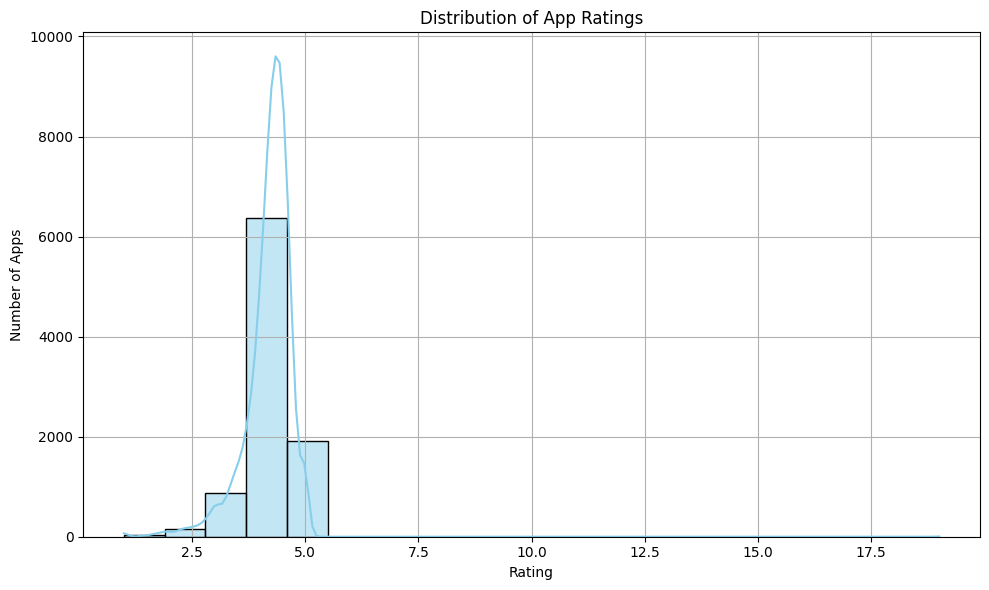

In [27]:
# Plot histogram of Ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['Rating'].dropna(), bins=20, kde=True, color='skyblue')
plt.title("Distribution of App Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Apps")
plt.grid(True)
plt.tight_layout()
plt.show()
#histogram

/tmp/ipython-input-29-1710968814.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Installs', y='Category', data=df_installs, palette='Spectral')


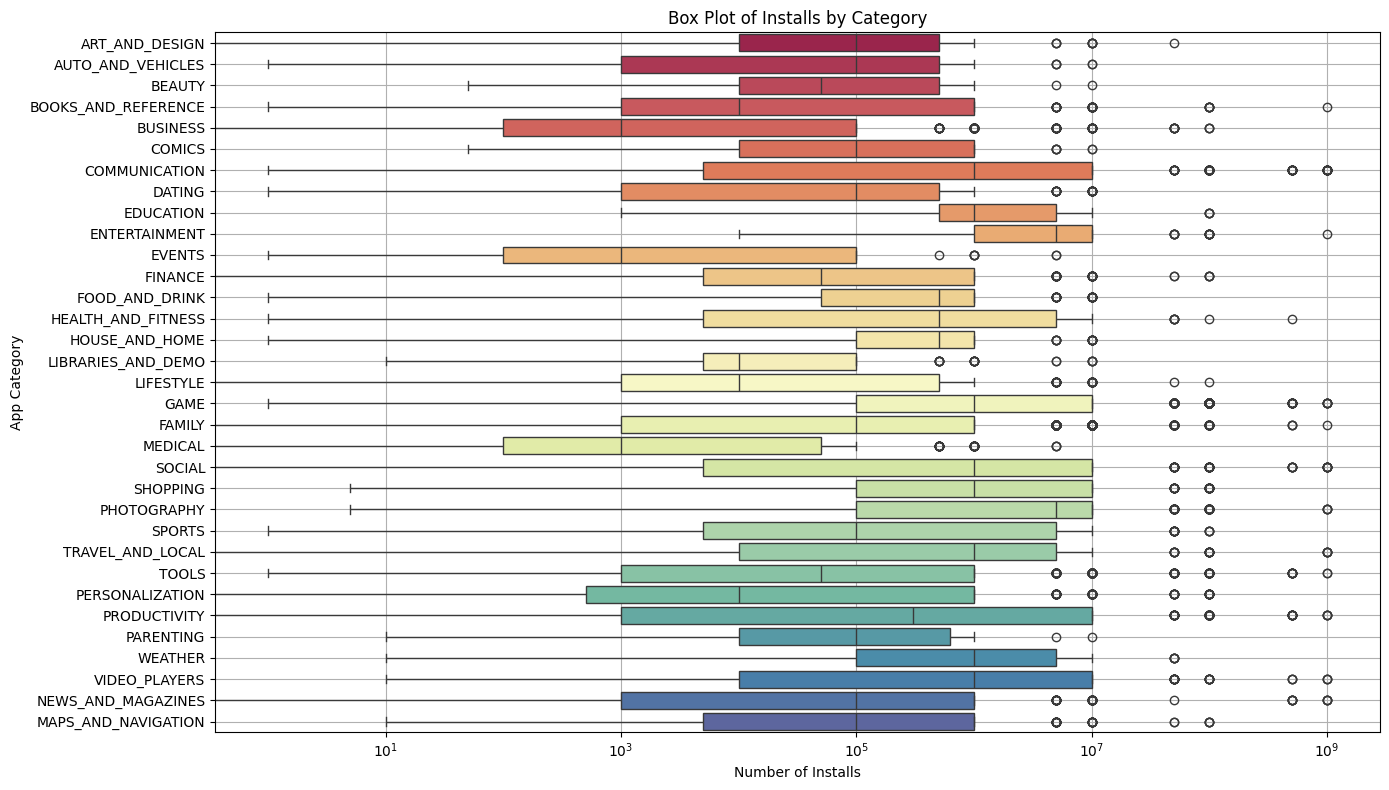

In [29]:
# Clean and convert 'Installs'
df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Drop NaNs
df_installs = df.dropna(subset=["Installs", "Category"])

# Plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Installs', y='Category', data=df_installs, palette='Spectral')
plt.title("Box Plot of Installs by Category")
plt.xlabel("Number of Installs")
plt.ylabel("App Category")
plt.xscale('log')  # Use log scale to handle wide range
plt.grid(True)
plt.tight_layout()
plt.show()
#box plot

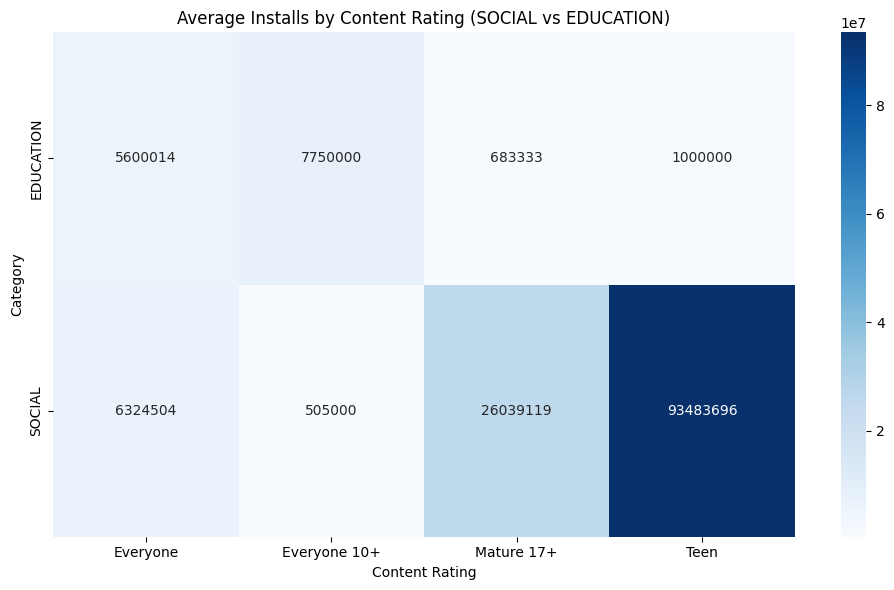

In [32]:
# Convert Installs column to string first
df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Filter for SOCIAL and EDUCATION categories
df_filtered = df[df['Category'].isin(['SOCIAL', 'EDUCATION'])]

# Create pivot table: average installs by Content Rating and Category
pivot = df_filtered.pivot_table(index='Category', columns='Content Rating', values='Installs', aggfunc='mean', fill_value=0)

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title("Average Installs by Content Rating (SOCIAL vs EDUCATION)")
plt.xlabel("Content Rating")
plt.ylabel("Category")
plt.tight_layout()
plt.show()
#heatmap

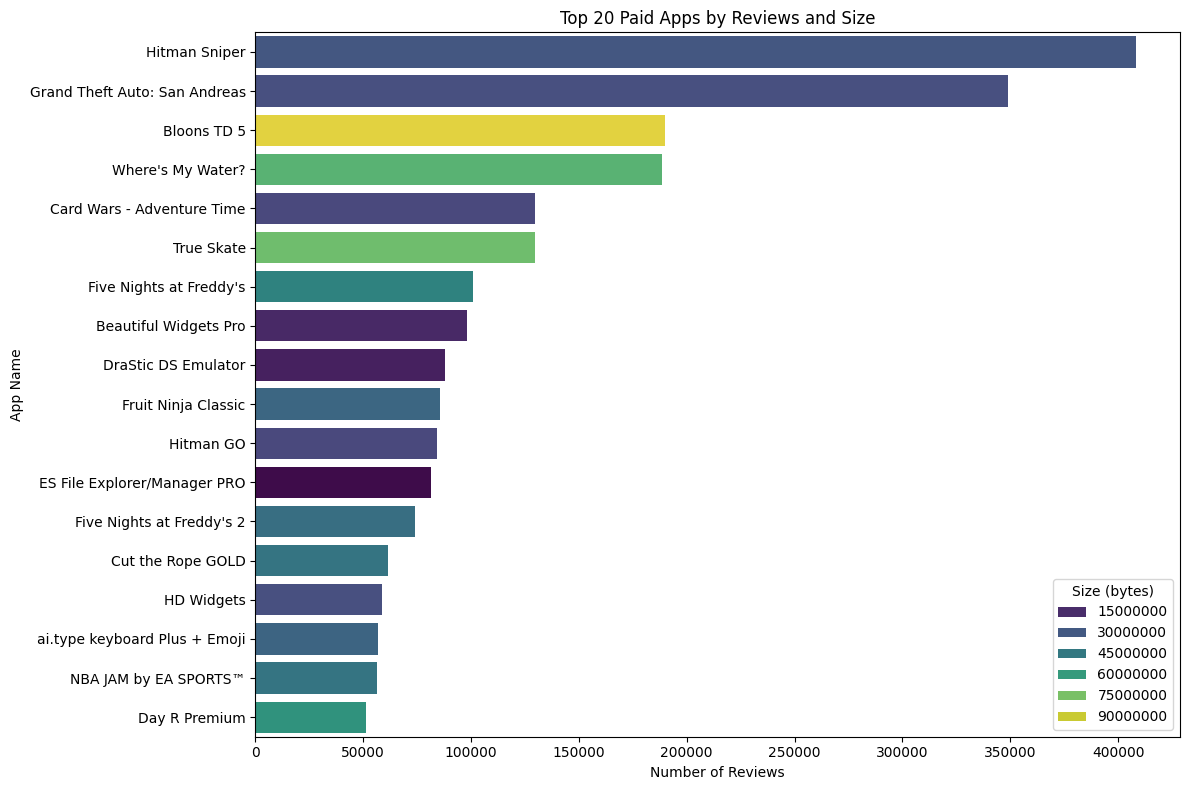

In [33]:
# Filter only paid apps
df_paid = df[df["Type"] == "Paid"].copy()

# Clean 'Size' column
def convert_size(size_str):
    if 'M' in size_str:
        return float(size_str.replace('M', '').replace(',', '')) * 1_000_000
    elif 'k' in size_str:
        return float(size_str.replace('k', '').replace(',', '')) * 1_000
    elif size_str == 'Varies with device':
        return None
    else:
        return None

df_paid['Size'] = df_paid['Size'].astype(str).apply(convert_size)
df_paid['Reviews'] = pd.to_numeric(df_paid['Reviews'], errors='coerce')

# Drop missing values
df_paid = df_paid.dropna(subset=['Size', 'Reviews', 'App'])

# Sort by Reviews (optional: you can sort by Size if preferred)
df_top = df_paid.sort_values(by='Reviews', ascending=False).head(20)

# Plot horizontal bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Reviews', y='App', data=df_top, hue='Size', dodge=False, palette='viridis')
plt.title("Top 20 Paid Apps by Reviews and Size")
plt.xlabel("Number of Reviews")
plt.ylabel("App Name")
plt.legend(title="Size (bytes)")
plt.tight_layout()
plt.show()
#horizontal bar graph

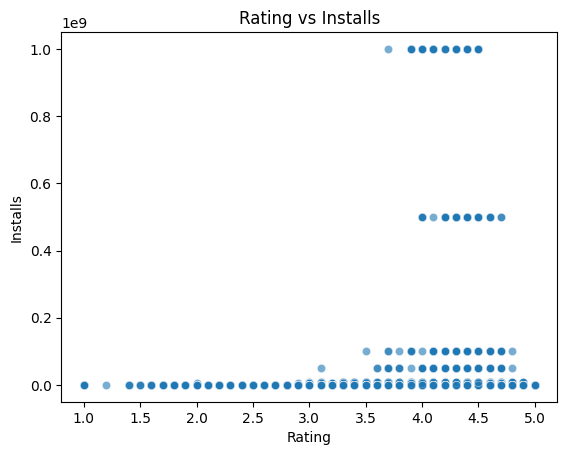

In [35]:
# Clean installs
df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Scatter plot
sns.scatterplot(data=df, x='Rating', y='Installs', alpha=0.6)
plt.title("Rating vs Installs")
plt.xlabel("Rating")
plt.ylabel("Installs")
plt.show()

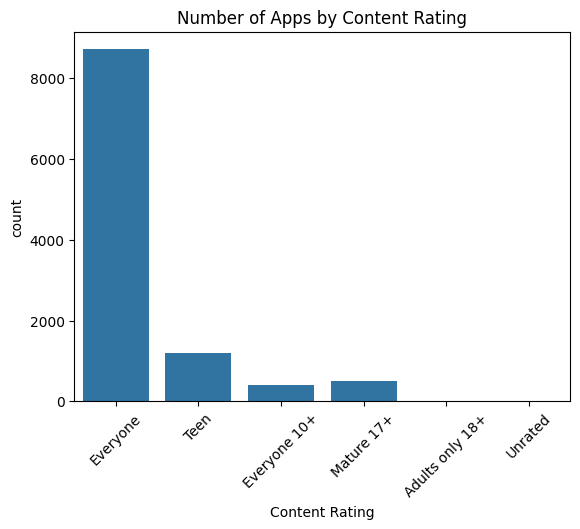

In [36]:
sns.countplot(data=df, x='Content Rating')
plt.title("Number of Apps by Content Rating")
plt.xticks(rotation=45)
plt.show()

/tmp/ipython-input-42-2567055629.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Rating', data=df_mature, palette='Set2', inner='box')


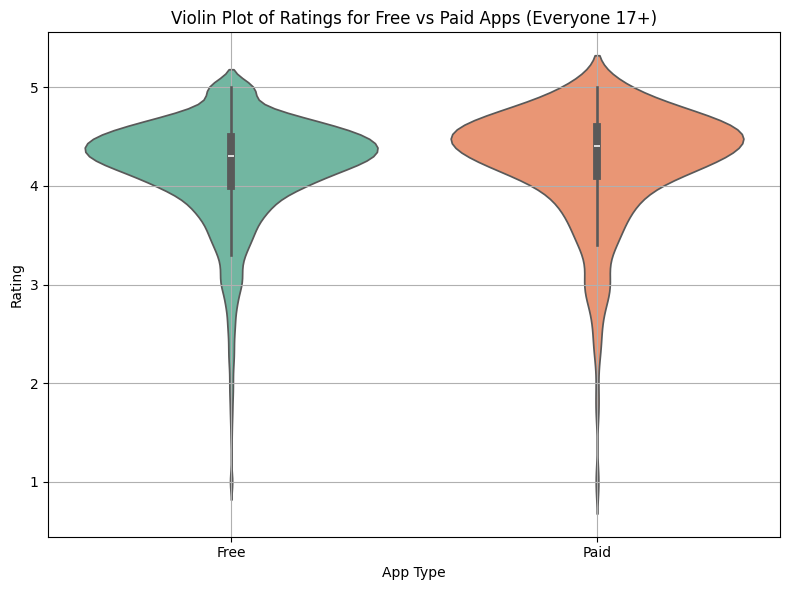

In [42]:
# Drop missing values for relevant columns
df = df.dropna(subset=['Rating', 'Type', 'Content Rating'])

# Filter for Mature 17+ apps only
df_mature = df[df['Content Rating'] == 'Everyone']

# Plot violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Type', y='Rating', data=df_mature, palette='Set2', inner='box')
plt.title("Violin Plot of Ratings for Free vs Paid Apps (Everyone)")
plt.xlabel("App Type")
plt.ylabel("Rating")
plt.grid(True)
plt.tight_layout()
plt.show()

## User Reviews

For this second file of the dataset we are not going to apply any cleaning or datatype conversion.

In [25]:
reviews = spark.read.load("googleplaystore_user_reviews.csv",
                    format='csv',
                    sep = ',',
                    header='true',
                    escape='"',
                    inferSchema='true').cache()

In [ ]:
reviews.count()

64295

In [ ]:
reviews.describe().show()

+-------+--------------------+------------------------+---------+--------------------+----------------------+
|summary|                 App|       Translated_Review|Sentiment|  Sentiment_Polarity|Sentiment_Subjectivity|
+-------+--------------------+------------------------+---------+--------------------+----------------------+
|  count|               64295|                   64290|    64295|               64295|                 64295|
|   mean|                NULL|                     NaN|      NaN|                 NaN|                   NaN|
| stddev|                NULL|                     NaN|      NaN|                 NaN|                   NaN|
|    min|10 Best Foods for...|    !!!Dont waste tim...| Negative|-0.00054112554112...|                   0.0|
|    max|Houzz Interior De...|搵楼租楼 A lot of tim...|      nan|                 nan|                   nan|
+-------+--------------------+------------------------+---------+--------------------+----------------------+



In [ ]:
reviews.createOrReplaceTempView("reviews")

# Business questions

### 1. Applications with at least 10.000 reviews, at least 50.000 installations and are supported on Android 4.0 and higher.

The tricky thing here is to find about Android number, since the column is a string and it has different values, some of them with text:

In [ ]:
spark.sql("""
SELECT DISTINCT `Android ver`
FROM apps
ORDER BY `Android ver`
""").show(40)

+------------------+
|       Android ver|
+------------------+
|              NULL|
|        1.0 and up|
|        1.5 and up|
|        1.6 and up|
|        2.0 and up|
|      2.0.1 and up|
|        2.1 and up|
|       2.2 - 7.1.1|
|        2.2 and up|
|        2.3 and up|
|      2.3.3 and up|
|        3.0 and up|
|        3.1 and up|
|        3.2 and up|
|        4.0 and up|
|     4.0.3 - 7.1.1|
|      4.0.3 and up|
|       4.1 - 7.1.1|
|        4.1 and up|
|        4.2 and up|
|        4.3 and up|
|        4.4 and up|
|       4.4W and up|
|         5.0 - 6.0|
|       5.0 - 7.1.1|
|         5.0 - 8.0|
|        5.0 and up|
|        5.1 and up|
|        6.0 and up|
|       7.0 - 7.1.1|
|        7.0 and up|
|        7.1 and up|
|        8.0 and up|
|  Health & Fitness|
| Maps & Navigation|
|               NaN|
|Varies with device|
+------------------+



We can use `regexp_replace` function to get the first 2 digits, since we need to filter by the major version number `4` and the minor version number `0`.

In [ ]:
# Isolated check of version filtering
spark.sql("""
SELECT DISTINCT REGEXP_REPLACE(`Android ver`,"","") vers
FROM apps
WHERE CAST(SUBSTRING(REGEXP_REPLACE(`Android ver`,"[^0-9]",""), 0, 1) as INT) >= 4
ORDER BY 1
""").show()

+-------------+
|         vers|
+-------------+
|   4.0 and up|
|4.0.3 - 7.1.1|
| 4.0.3 and up|
|  4.1 - 7.1.1|
|   4.1 and up|
|   4.2 and up|
|   4.3 and up|
|   4.4 and up|
|  4.4W and up|
|    5.0 - 6.0|
|  5.0 - 7.1.1|
|    5.0 - 8.0|
|   5.0 and up|
|   5.1 and up|
|   6.0 and up|
|  7.0 - 7.1.1|
|   7.0 and up|
|   7.1 and up|
|   8.0 and up|
+-------------+



Now the question can be easily answered.<br>
There is a total of 2133 apps that met those requirements.

In [ ]:
spark.sql("""
SELECT  App,
        Reviews,
        Installs,
        `Android Ver`,
        COUNT(*) OVER () total
FROM apps
WHERE Reviews >= 10000
  AND Installs >= 50000

  AND CAST(SUBSTRING(REGEXP_REPLACE(`Android ver`,"[^0-9]",""), 0, 1) as INT) >= 4
""").show()


+---+-------+--------+-----------+-----+
|App|Reviews|Installs|Android Ver|total|
+---+-------+--------+-----------+-----+
+---+-------+--------+-----------+-----+



In [ ]:
spark.sql(""" SELECT Reviews,Installs from apps WHERE Reviews >= 1000 """).show()

+-------+-----------+
|Reviews|   Installs|
+-------+-----------+
|   4925| 1,000,000+|
|   3031|   500,000+|
|  40467| 1,000,000+|
|   2019|   100,000+|
|   2490|   500,000+|
| 105766|10,000,000+|
|  74359| 1,000,000+|
|  48732|10,000,000+|
|  23160| 1,000,000+|
| 214878|10,000,000+|
|  14153| 1,000,000+|
|   4379| 1,000,000+|
| 115773|10,000,000+|
|  11506|   100,000+|
|  41605|   500,000+|
|   4649|   100,000+|
| 768833|50,000,000+|
|  15880| 1,000,000+|
|   1886|   500,000+|
|  48253| 1,000,000+|
+-------+-----------+
only showing top 20 rows



### 2. Top 10 applications in regards to the highest number of positive sentiments.

In [ ]:
spark.sql("""
SELECT app, count(*) cnt_pos
FROM reviews
WHERE sentiment = "Positive"
GROUP BY app
ORDER BY 2 DESC
LIMIT 10
""").show(truncate=False)

+------------------------------+-------+
|app                           |cnt_pos|
+------------------------------+-------+
|Helix Jump                    |209    |
|Duolingo: Learn Languages Free|200    |
|Calorie Counter - Macros      |174    |
|Calorie Counter - MyFitnessPal|169    |
|Bowmasters                    |169    |
|10 Best Foods for You         |162    |
|Google Photos                 |143    |
|8fit Workouts & Meal Planner  |137    |
|Garena Free Fire              |136    |
|DRAGON BALL LEGENDS           |127    |
+------------------------------+-------+



### 3. Histogram for the number of installations.

We use the SQL function `NVL` to replace NULL values with 0.

In [ ]:
histogram = spark.sql("""
SELECT  NVL(installs, 0) installs
        , count(*) frequency
FROM apps
GROUP BY NVL(installs, 0)
ORDER BY 1
""")

In [ ]:
# Programmatic way to replace NULL with 0
histogram = histogram.fillna(0, "installs")

In [ ]:
histogram.where("installs is null").show()

+--------+---------+
|installs|frequency|
+--------+---------+
+--------+---------+



In [ ]:
histogram.show()

+--------------+---------+
|      installs|frequency|
+--------------+---------+
|             0|        1|
|            0+|       14|
|            1+|       67|
|        1,000+|      887|
|    1,000,000+|     1418|
|1,000,000,000+|       20|
|           10+|      385|
|       10,000+|     1031|
|   10,000,000+|      935|
|          100+|      710|
|      100,000+|     1111|
|  100,000,000+|      189|
|           4.2|        1|
|           4.4|        1|
|            5+|       82|
|        5,000+|      468|
|    5,000,000+|      605|
|           50+|      204|
|       50,000+|      469|
|   50,000,000+|      204|
+--------------+---------+
only showing top 20 rows



Now that we have the data we want to show, we need to convert to Pandas Dataframe so later we can use a the Pandas internal plot library.

In [ ]:
# Conversion: Spark DF to Pandas DF
plotdf = histogram.toPandas()

<Axes: ylabel='installs'>

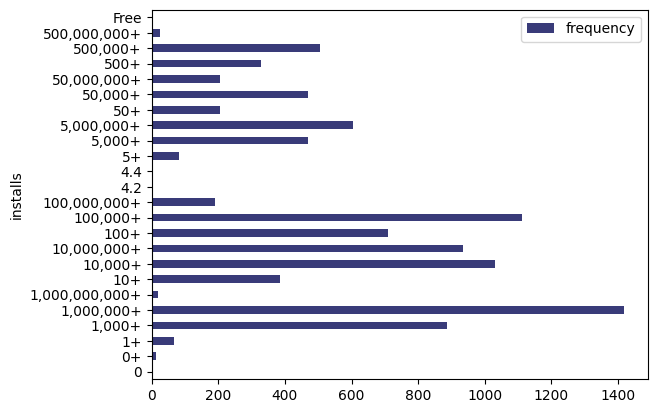

In [ ]:
# Pandas internal plot library
plotdf.plot(kind='barh', x='installs', y='frequency', colormap='tab20b')

### 4. How many distinct genres there are? How many apps for each genre?

In the dataset there is an **invalid row** where `Category` column is missing (this is different than having a NULL or empty value), so all the following columns for that row are affected. We can simply ignore this row in the following cells of this notebook.

In [ ]:
# Wrong case detected
spark.sql("""
SELECT *
FROM apps
where genres = "February 11, 2018"
""").show()

+--------------------+------+-------+--------+--------+-----------------+------------+-----------+-----------+
|                 App|Rating|Reviews|Installs|   Price|           Genres|Last Updated|Current Ver|Android Ver|
+--------------------+------+-------+--------+--------+-----------------+------------+-----------+-----------+
|Life Made WI-Fi T...|    19|   3.0M|    Free|Everyone|February 11, 2018|      1.0.19| 4.0 and up|       NULL|
+--------------------+------+-------+--------+--------+-----------------+------------+-----------+-----------+



In this case we need to separate all the different groups of genres into a single one.<br>
To do that, we use a combination of `split` and `explode` functions.

A first step is to get all the genre values in list objects, since explode uses a list/array to later decompose them.

In [ ]:
spark.sql("""
SELECT DISTINCT SPLIT(genres, ";") genres
FROM apps
ORDER BY 1
""").show(30, truncate=False)

+----------------------------------+
|genres                            |
+----------------------------------+
|[Action]                          |
|[Action, Action & Adventure]      |
|[Adventure]                       |
|[Adventure, Action & Adventure]   |
|[Adventure, Brain Games]          |
|[Adventure, Education]            |
|[Arcade]                          |
|[Arcade, Action & Adventure]      |
|[Arcade, Pretend Play]            |
|[Art & Design]                    |
|[Art & Design, Action & Adventure]|
|[Art & Design, Creativity]        |
|[Art & Design, Pretend Play]      |
|[Auto & Vehicles]                 |
|[Beauty]                          |
|[Board]                           |
|[Board, Action & Adventure]       |
|[Board, Brain Games]              |
|[Board, Pretend Play]             |
|[Books & Reference]               |
|[Books & Reference, Creativity]   |
|[Books & Reference, Education]    |
|[Business]                        |
|[Card]                            |
|

With the following query, we obtain all the different genres, a total of 54.

In [ ]:
genresDF = spark.sql("""
SELECT DISTINCT EXPLODE(SPLIT(genres, ";")) genres
FROM apps
ORDER BY 1
""")

In [ ]:
genresDF.count()

55

In [ ]:


genresDF.show()

+------------------+
|            genres|
+------------------+
|            Action|
|Action & Adventure|
|         Adventure|
|            Arcade|
|      Art & Design|
|   Auto & Vehicles|
|            Beauty|
|             Board|
| Books & Reference|
|       Brain Games|
|          Business|
|              Card|
|            Casino|
|            Casual|
|            Comics|
|     Communication|
|        Creativity|
|            Dating|
|         Education|
|       Educational|
+------------------+
only showing top 20 rows



For the second question related to genres, we need to use the previous query without `DISTINCT`, because we need every row (every app).<br>We can see that the top 3 genres for apps are *Tools*, *Education* and *Entertainment*.

In [ ]:
spark.sql("""
WITH app_vw AS
    (SELECT EXPLODE(SPLIT(genres, ";")) genres
    FROM apps)
SELECT genres, count(*) number_apps
FROM app_vw
GROUP BY genres
ORDER BY 2 DESC
""").show()

+-----------------+-----------+
|           genres|number_apps|
+-----------------+-----------+
|            Tools|        829|
|        Education|        678|
|    Entertainment|        592|
|         Business|        419|
|          Medical|        395|
|  Personalization|        376|
|     Productivity|        374|
|        Lifestyle|        370|
|          Finance|        345|
|           Sports|        335|
|    Communication|        317|
|           Action|        311|
| Health & Fitness|        289|
|      Photography|        281|
| News & Magazines|        254|
|           Social|        239|
|Books & Reference|        225|
|           Casual|        224|
|   Travel & Local|        219|
|       Simulation|        206|
+-----------------+-----------+
only showing top 20 rows



### 5. Applications with more positive sentiments than negative and neutral together and having a rating of at least 4.2.

Let's first see how is the sentiment distribution among the reviews.

In [ ]:
spark.sql("""
SELECT DISTINCT sentiment
        , COUNT(*) OVER(PARTITION BY sentiment) sent_tot
        , COUNT(*) OVER() total
        , ROUND(COUNT(*) OVER(PARTITION BY sentiment) / COUNT(*) OVER() * 100, 2) percent
FROM reviews
""").show()

+---------+--------+-----+-------+
|sentiment|sent_tot|total|percent|
+---------+--------+-----+-------+
| Negative|    8271|64295|  12.86|
|  Neutral|    5163|64295|   8.03|
| Positive|   23998|64295|  37.32|
|      nan|   26863|64295|  41.78|
+---------+--------+-----+-------+



In the following query we count the different sentiments for each app:

In [ ]:
spark.sql("""
SELECT  app,
        SUM(CASE sentiment WHEN "Positive" THEN 1 ELSE 0 END) positive,
        SUM(CASE sentiment WHEN "Negative" THEN 1 ELSE 0 END) negative,
        SUM(CASE sentiment WHEN "Neutral" THEN 1 ELSE 0 END) neutral
FROM reviews r
WHERE r.sentiment != "nan"
GROUP BY app
""").show(truncate=False)

+-------------------------------------+--------+--------+-------+
|app                                  |positive|negative|neutral|
+-------------------------------------+--------+--------+-------+
|BaBe+ - Berita Indonesia             |13      |2       |5      |
|Basketball Stars                     |44      |41      |4      |
|Davis's Drug Guide for Nurses        |2       |0       |1      |
|Find&Save - Local Shopping           |20      |7       |4      |
|Bloomberg Professional               |15      |11      |14     |
|Floor Plan Creator                   |26      |3       |8      |
|Bagan - Myanmar Keyboard             |21      |2       |9      |
|Candy Pop Story                      |22      |13      |5      |
|Cricbuzz - Live Cricket Scores & News|26      |11      |1      |
|AOL - News, Mail & Video             |17      |7       |9      |
|Epocrates Plus                       |29      |6       |5      |
|File Explorer                        |14      |3       |6      |
|Arrow.io 

Using the previous query as a view, we can now get the final answer:

In [ ]:
spark.sql("""
WITH reviews_vw AS
    (SELECT app,
            SUM(CASE sentiment WHEN "Positive" THEN 1 ELSE 0 END) positive,
            SUM(CASE sentiment WHEN "Negative" THEN 1 ELSE 0 END) negative,
            SUM(CASE sentiment WHEN "Neutral" THEN 1 ELSE 0 END) neutral
    FROM reviews r
    WHERE r.sentiment != "nan"
    GROUP BY app
    )
SELECT a.app, a.rating, positive, negative, neutral
FROM apps a, reviews_vw r
WHERE a.app = r.app
AND a.rating >= 4.2
AND positive > neutral + negative
""").show(30, truncate=False)

+--------------------------------------------------+------+--------+--------+-------+
|app                                               |rating|positive|negative|neutral|
+--------------------------------------------------+------+--------+--------+-------+
|Davis's Drug Guide for Nurses                     |4.5   |2       |0       |1      |
|Candy Pop Story                                   |4.7   |22      |13      |5      |
|Cricbuzz - Live Cricket Scores & News             |4.5   |26      |11      |1      |
|Epocrates Plus                                    |4.3   |29      |6       |5      |
|Arrow.io                                          |4.5   |53      |28      |14     |
|CALCU™ Stylish Calculator Free                    |4.7   |27      |1       |10     |
|FilterGrid - Cam&Photo Editor                     |4.6   |22      |9       |4      |
|BELONG Beating Cancer Together                    |4.7   |28      |2       |8      |
|Bubble Shooter                                    |4.

### 6. Trying to find correlation between some of the attributes.

In the **first case**, I tried to find some correlation between sentiment and rating.<br>
What I found is that rating is mostly similar in both very positive and negative sentiments. I would have expected much worse rating for those with negative sentiment, but the data shows that it's only slightly lower.

**Positive sentiment**

In [ ]:
spark.sql("""
WITH apps_vw AS
    (SELECT app, rating, reviews, installs, price, genres
    FROM apps
    ),
reviews_vw AS
    (SELECT app,
            SUM(CASE sentiment WHEN "Positive" THEN 1 ELSE 0 END) positive,
            SUM(CASE sentiment WHEN "Negative" THEN 1 ELSE 0 END) negative,
            SUM(CASE sentiment WHEN "Neutral" THEN 1 ELSE 0 END) neutral
    FROM reviews r
    WHERE r.sentiment != "nan"
    GROUP BY app
    )
SELECT a.app, price, rating, installs, reviews, positive, negative, neutral
FROM apps_vw a, reviews_vw r
WHERE a.app = r.app
AND positive > negative + neutral
ORDER BY positive DESC
""").show()

+--------------------+-----+------+--------------+--------+--------+--------+-------+
|                 app|price|rating|      installs| reviews|positive|negative|neutral|
+--------------------+-----+------+--------------+--------+--------+--------+-------+
|          Helix Jump|    0|   4.2|  100,000,000+| 1500999|     209|      58|      6|
|Duolingo: Learn L...|    0|   4.7|  100,000,000+| 6297590|     200|      34|      6|
|Calorie Counter -...|    0|   4.0|      100,000+|    3061|     174|      20|      6|
|          Bowmasters|    0|   4.7|   50,000,000+| 1536349|     169|     119|     24|
|Calorie Counter -...|    0|   4.6|   50,000,000+| 1873523|     169|      52|     34|
|10 Best Foods for...|    0|   4.0|      500,000+|    2490|     162|      10|     22|
|       Google Photos|    0|   4.5|1,000,000,000+|10859051|     143|      47|      1|
|8fit Workouts & M...|    0|   4.6|   10,000,000+|  115721|     137|      19|     15|
|    Garena Free Fire|    0|   4.5|  100,000,000+| 553

**Negative sentiment**

In [ ]:
spark.sql("""
WITH apps_vw AS
    (SELECT app, rating, reviews, installs, price, genres
    FROM apps
    ),
reviews_vw AS
    (SELECT app,
            SUM(CASE sentiment WHEN "Positive" THEN 1 ELSE 0 END) positive,
            SUM(CASE sentiment WHEN "Negative" THEN 1 ELSE 0 END) negative,
            SUM(CASE sentiment WHEN "Neutral" THEN 1 ELSE 0 END) neutral
    FROM reviews r
    WHERE r.sentiment != "nan"
    GROUP BY app
    )
SELECT a.app, price, rating, installs, reviews, negative, positive, neutral
FROM apps_vw a, reviews_vw r
WHERE a.app = r.app
AND negative > positive + neutral
ORDER BY negative DESC
""").show()

+--------------------+-----+------+------------+--------+--------+--------+-------+
|                 app|price|rating|    installs| reviews|negative|positive|neutral|
+--------------------+-----+------+------------+--------+--------+--------+-------+
| Angry Birds Classic|    0|   4.4|100,000,000+| 5566908|     147|     124|      2|
|    Candy Crush Saga|    0|   4.4|500,000,000+|22430188|     126|     102|     12|
|Candy Crush Soda ...|    0|   4.4|100,000,000+| 6199095|      96|      62|      8|
|       Cooking Fever|    0|   4.5|100,000,000+| 3198176|      79|      55|      1|
| Be A Legend: Soccer|    0|   3.8|  1,000,000+|   85763|      59|      33|      6|
|Candy Crush Jelly...|    0|   4.3| 50,000,000+| 1300619|      44|      21|      8|
|     Angry Birds Rio|    0|   4.4|100,000,000+| 2610680|      23|      15|      1|
|GoPro (formerly C...|    0|   4.0| 10,000,000+|  157506|      23|      15|      1|
|       Guns of Glory|    0|   4.0| 10,000,000+|  120592|      23|      14| 

In the **second case**, I tried to find correlation between price and number of installations.<br>
The most expensive apps are not frequently installed.

In [ ]:
spark.sql("""
SELECT app, price, rating, installs, genres, reviews
FROM apps
ORDER BY price DESC, installs
""").show(30, truncate=False)

+---------------------------------------+------------------+-----------+--------+-----------------+-------------+
|app                                    |price             |rating     |installs|genres           |reviews      |
+---------------------------------------+------------------+-----------+--------+-----------------+-------------+
|"Yanosik: ""antyradar""                |Varies with device| navigation|4.4     |Free             | camera"     |
|Life Made WI-Fi Touchscreen Photo Frame|Everyone          |19         |Free    |February 11, 2018|3.0M         |
|"Women""s Health Tips(Breast           |5.0M              |Body       |4.2     |Free             |weight lose)"|
|Command & Conquer: Rivals              |0                 |NaN        |0       |Strategy         |0            |
|CX Network                             |0                 |NaN        |0+      |Business         |0            |
|Pekalongan CJ                          |0                 |NaN        |0+      |Social 

And showing the opposite side, the cheaper the app is, the more times it gets installed.

In [ ]:
spark.sql("""
SELECT    CASE WHEN price = 0 THEN 1 ELSE 0 END Free
        , CASE WHEN price > 0 AND price <= 10 THEN 1 ELSE 0 END `0.1to10`
        , CASE WHEN price > 10 AND price <= 20 THEN 1 ELSE 0 END `10to20`
        , CASE WHEN price > 20 AND price <= 50 THEN 1 ELSE 0 END `20to50`
        , CASE WHEN price > 50 AND price <= 100 THEN 1 ELSE 0 END `50to100`
        , CASE WHEN price > 100 AND price <= 200 THEN 1 ELSE 0 END `100to200`
        , CASE WHEN price > 200 AND price <= 300 THEN 1 ELSE 0 END `200to300`
        , CASE WHEN price > 300 AND price <= 400 THEN 1 ELSE 0 END `300to400`
        , SUM(installs) total_installs
FROM apps
GROUP BY 1, 2, 3, 4, 5, 6, 7, 8
ORDER BY 9 DESC
""").show()

+----+-------+------+------+-------+--------+--------+--------+-----------------+
|Free|0.1to10|10to20|20to50|50to100|100to200|200to300|300to400|   total_installs|
+----+-------+------+------+-------+--------+--------+--------+-----------------+
|   0|      0|     0|     0|      0|       0|       0|       0|8.600000000000001|
|   1|      0|     0|     0|      0|       0|       0|       0|              0.0|
+----+-------+------+------+-------+--------+--------+--------+-----------------+



We can show what percentage represents each of the values and have a better idea of the distribution.<br>
In order to do that, we use the previous query as a view:

In [ ]:
spark.sql("""
WITH app_vw AS
        (select   CASE WHEN price = 0 THEN 1 ELSE 0 END Free
                , CASE WHEN price > 0 AND price <= 10 THEN 1 ELSE 0 END `0.1to10`
                , CASE WHEN price > 10 AND price <= 20 THEN 1 ELSE 0 END `10to20`
                , CASE WHEN price > 20 AND price <= 50 THEN 1 ELSE 0 END `20to50`
                , CASE WHEN price > 50 AND price <= 100 THEN 1 ELSE 0 END `50to100`
                , CASE WHEN price > 100 AND price <= 200 THEN 1 ELSE 0 END `100to200`
                , CASE WHEN price > 200 AND price <= 300 THEN 1 ELSE 0 END `200to300`
                , CASE WHEN price > 300 AND price <= 400 THEN 1 ELSE 0 END `300to400`
                , SUM(installs) total_installs
        from apps
        GROUP BY 1, 2, 3, 4, 5, 6, 7, 8)
SELECT *,
       ROUND(total_installs / SUM(total_installs) OVER () * 100, 2) percent
FROM app_vw
ORDER BY 9 DESC
""").show()

+----+-------+------+------+-------+--------+--------+--------+-----------------+-------+
|Free|0.1to10|10to20|20to50|50to100|100to200|200to300|300to400|   total_installs|percent|
+----+-------+------+------+-------+--------+--------+--------+-----------------+-------+
|   0|      0|     0|     0|      0|       0|       0|       0|8.600000000000001|  100.0|
|   1|      0|     0|     0|      0|       0|       0|       0|              0.0|    0.0|
+----+-------+------+------+-------+--------+--------+--------+-----------------+-------+



In the **third case**, I tried to find correlation between rating and number of installations.<br>
It's clear here that higher rated apps are more frequently installed. (*last row are apps with NULL rating*)

In [ ]:
spark.sql("""
SELECT CASE WHEN rating <= 2 THEN 1 ELSE 0 END `0-2`
        , CASE WHEN rating > 2 AND rating <= 3 THEN 1 ELSE 0 END `2-3`
        , CASE WHEN rating > 3 AND rating <= 4 THEN 1 ELSE 0 END `3-4`
        , CASE WHEN rating > 4 AND rating <= 5 THEN 1 ELSE 0 END `4-5`
        , SUM(installs)
FROM apps
GROUP BY 1, 2, 3, 4
ORDER BY 5 DESC
""").show()

+---+---+---+---+-----------------+
|0-2|2-3|3-4|4-5|    sum(installs)|
+---+---+---+---+-----------------+
|  0|  0|  0|  0|8.600000000000001|
|  0|  0|  0|  1|             NULL|
|  1|  0|  0|  0|             NULL|
|  0|  0|  1|  0|             NULL|
|  0|  1|  0|  0|             NULL|
+---+---+---+---+-----------------+

